In [1]:
from __future__ import annotations
import time
import tkinter
import pathlib
import pickle
import tifffile
import os
import numpy as np
from PIL import (Image, ImageTk, ImageDraw)
from tkinter import filedialog, messagebox
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, NavigationToolbar2Tk)
from matplotlib.patches import Rectangle, Circle
from matplotlib.backend_bases import MouseEvent
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt
from skimage import measure
import fishCore
import fishGUI
import threading
import concurrent.futures
import cv2
import imageio.v3 as iio
import napari
from aicsimageio import AICSImage

f = fishCore.Fish(pathlib.Path("./config.ini"))
f.set_model_version("3.50")

c:\Users\tkpp2\miniconda3\envs\fish\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


final text_encoder_type: bert-base-uncased


[2025-07-03 14:40:02,472][INFO] CHECK: Model version 3.50 loaded


In [2]:
def helper__hdr2Rgb(hdr_image: np.ndarray, dynamic_range: int) -> np.ndarray:
        scale_factor = 255 / dynamic_range # 65536
        scaled_image = (hdr_image * scale_factor).astype(np.uint8)
        rgb_image = np.stack((scaled_image,) * 3, axis=-1)
        return rgb_image

def helper__hdr2RgbNorm(hdr_image: np.ndarray, brightness_factor: int) -> np.ndarray:
        img_normalized = cv2.normalize(hdr_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img_rgb = cv2.cvtColor(img_normalized, cv2.COLOR_GRAY2RGB)
        return np.clip(img_rgb * brightness_factor, 0, 255).astype(np.uint8)

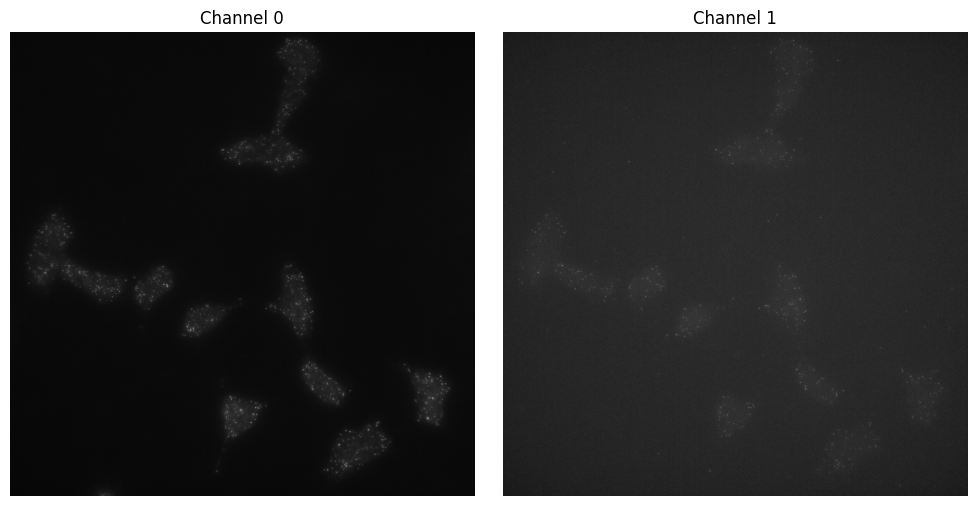

In [10]:
image_path = pathlib.Path(r"assets\Composite Images (Multi-Channel)\488_pb5sp4_s1.composite.tif")
img = tifffile.imread(image_path)  # shape: (2, H, W)
img = img.transpose(1, 2, 0)  # shape: (H, W, 2)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img[:, :, 0], cmap='gray')
axes[0].set_title("Channel 0")
axes[0].axis('off')

axes[1].imshow(img[:, :, 1], cmap='gray')
axes[1].set_title("Channel 1")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [4]:
with tifffile.TiffFile(image_path) as tif:
    print(tif.pages[0].tags)
    print()
    print(tif.pages[1].tags)

TiffTag 254 NewSubfileType @10 LONG @18 = UNDEFINED
TiffTag 256 ImageWidth @22 LONG @30 = 2048
TiffTag 257 ImageLength @34 LONG @42 = 2048
TiffTag 258 BitsPerSample @46 SHORT @54 = 16
TiffTag 259 Compression @58 SHORT @66 = NONE
TiffTag 262 PhotometricInterpretation @70 SHORT @78 = MINISBLACK
TiffTag 270 ImageDescription @82 ASCII[80] @170 = ImageJ=1.54f images=3 channel
TiffTag 273 StripOffsets @94 LONG @102 = (2642,)
TiffTag 277 SamplesPerPixel @106 SHORT @114 = 1
TiffTag 278 RowsPerStrip @118 LONG @126 = 2048
TiffTag 279 StripByteCounts @130 LONG @138 = (8388608,)
TiffTag 50838 IJMetadataByteCounts @142 LONG[5] @250 = (20, 48, 768, 768, 768)
TiffTag 50839 IJMetadata @154 BYTE[2372] @270 = {'LUTs': [array([[0, 1, 2, ...,

TiffTag 254 NewSubfileType @25168468 LONG @25168476 = UNDEFINED
TiffTag 256 ImageWidth @25168480 LONG @25168488 = 2048
TiffTag 257 ImageLength @25168492 LONG @25168500 = 2048
TiffTag 258 BitsPerSample @25168504 SHORT @25168512 = 16
TiffTag 259 Compression @25168516 

In [5]:
with tifffile.TiffFile(image_path) as tif:
    print(tif.pages[0].tags['ImageDescription'].value)
    print()
    print(tif.pages[1].tags['ImageDescription'].value)

ImageJ=1.54f
images=3
channels=3
mode=composite
loop=false
min=200.0
max=400.0

ImageJ=1.54f
images=3
channels=3
mode=composite
loop=false
min=200.0
max=400.0


In [6]:
with tifffile.TiffFile(pathlib.Path("./assets/demotifs/MAX_H_w1-358 DAPI_s001.tif")) as tif:
    print(tif.pages[0].tags)

TiffTag 256 ImageWidth @8452258 SHORT @8452266 = 2048
TiffTag 257 ImageLength @8452270 SHORT @8452278 = 2048
TiffTag 258 BitsPerSample @8452282 SHORT @8452290 = 16
TiffTag 259 Compression @8452294 SHORT @8452302 = PACKBITS
TiffTag 262 PhotometricInterpretation @8452306 SHORT @8452314 = MINISBLACK
TiffTag 273 StripOffsets @8452318 LONG[64] @8452702 = (8, 132075, 264145, 39620
TiffTag 274 Orientation @8452330 SHORT @8452338 = TOPLEFT
TiffTag 277 SamplesPerPixel @8452342 SHORT @8452350 = 1
TiffTag 278 RowsPerStrip @8452354 SHORT @8452362 = 32
TiffTag 279 StripByteCounts @8452366 LONG[64] @8452446 = (132067, 132070, 13206
TiffTag 282 XResolution @8452378 RATIONAL @8452430 = (72, 1)
TiffTag 283 YResolution @8452390 RATIONAL @8452438 = (72, 1)
TiffTag 284 PlanarConfiguration @8452402 SHORT @8452410 = CONTIG
TiffTag 296 ResolutionUnit @8452414 SHORT @8452422 = INCH


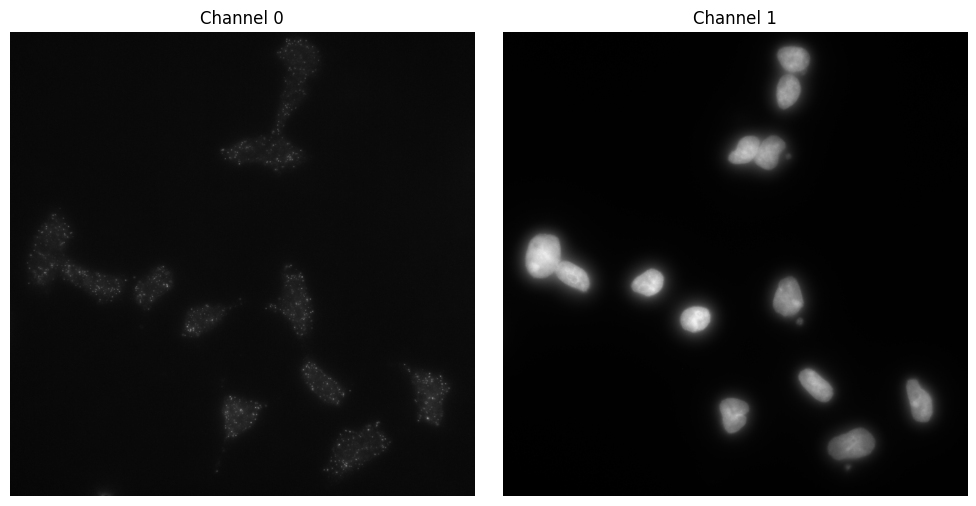

In [7]:
with tifffile.TiffFile(image_path) as tif:
    img0 = tif.pages[0].asarray()
    img1 = tif.pages[2].asarray()
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img0, cmap='gray')
    axes[0].set_title("Channel 0")
    axes[0].axis('off')

    axes[1].imshow(img1, cmap='gray')
    axes[1].set_title("Channel 1")
    axes[1].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# with tifffile.TiffFile(image_path) as tif:
#     viewer = napari.Viewer()

#     for i in range(len(tif.pages)):
#         viewer.add_image(
#             tif.pages[i].asarray(),
#             name=f"Channel {i}",
#             colormap='green' if i == 0 else 'magenta',
#             blending='additive',
#             opacity=0.7 if i == 1 else 1.0
#         )

#     napari.run()

[2025-07-03 17:36:23,605][INFO] PRED: generated 13 masks
[2025-07-03 17:36:35,280][INFO] PRED: generated 13 masks
[2025-07-03 17:36:45,899][INFO] PRED: generated 13 masks


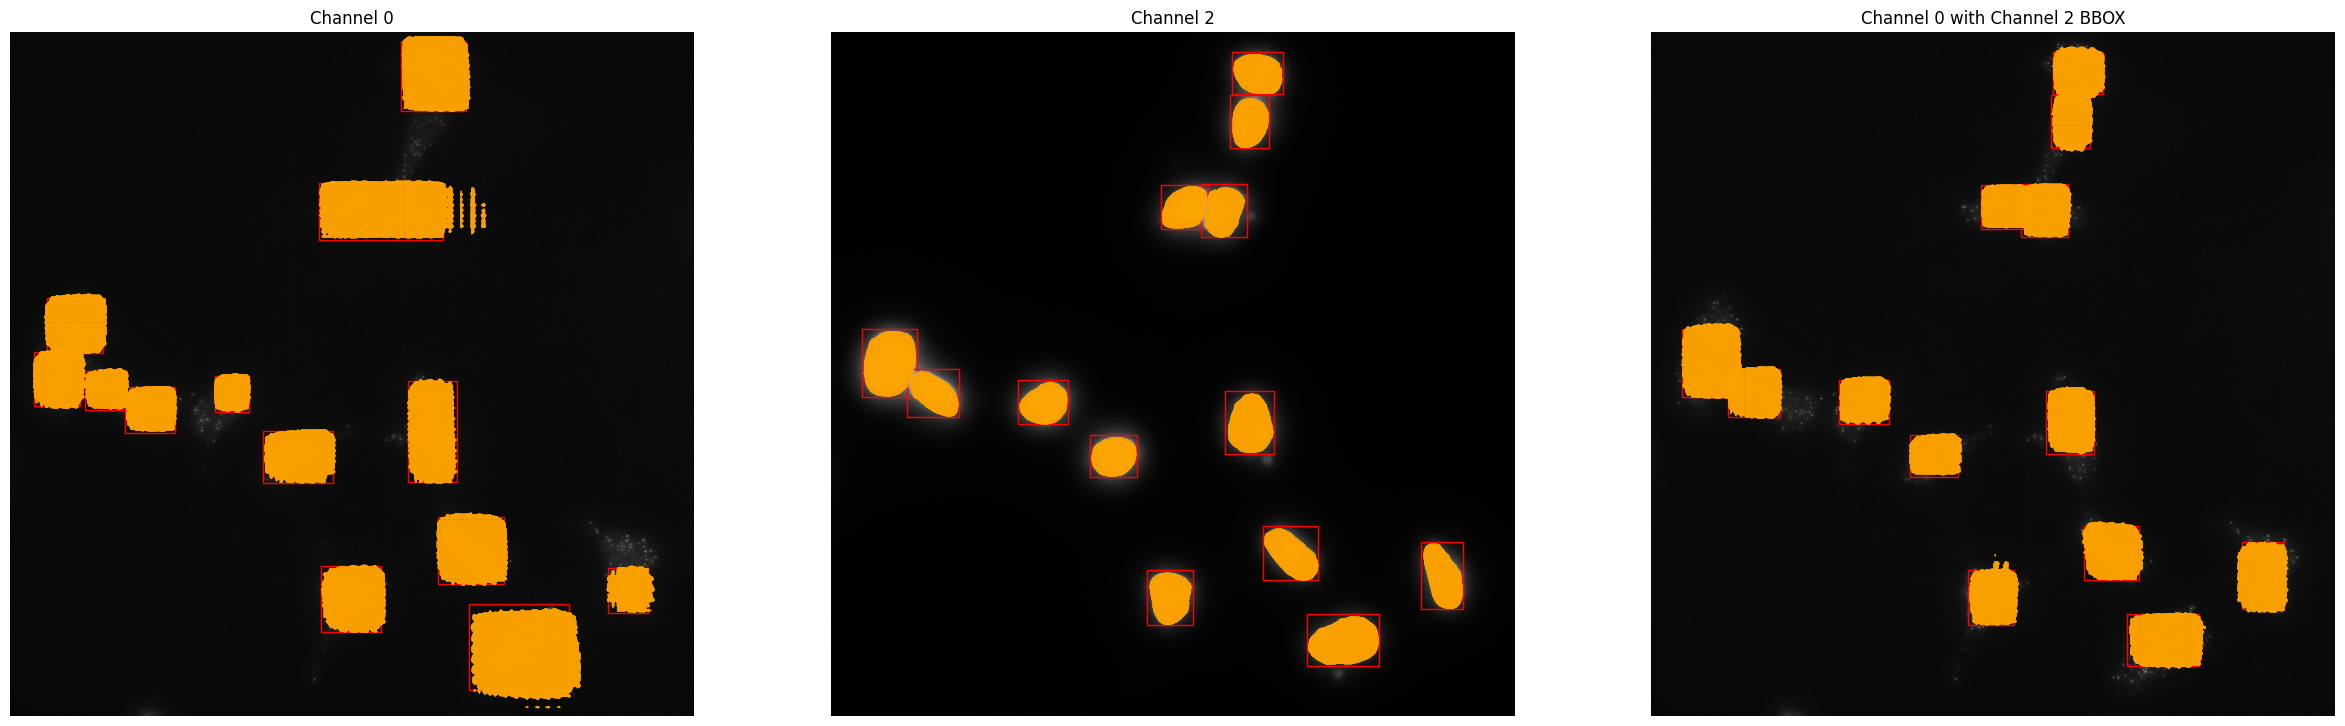

In [11]:
with tifffile.TiffFile(image_path) as tif:
    img0 = tif.pages[0].asarray()
    img1 = tif.pages[2].asarray()
    
    bbox0 = f.AppIntDINOwrapper(img0)
    bbox1 = f.AppIntDINOwrapper(img1)
    result0 = f.finetune.AppIntPREDICTwrapper(img0,bbox0)
    result1 = f.finetune.AppIntPREDICTwrapper(img1,bbox1)
    result0_by_b1 = f.finetune.AppIntPREDICTwrapper(img0,bbox1)
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].imshow(img0, cmap='gray')
    axes[0].set_title("Channel 0")
    axes[0].axis('off')
    for bbox in bbox0:
        axes[0].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result0:
        y, x = np.where(mask > 0)
        axes[0].scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    
    axes[1].imshow(img1, cmap='gray')
    axes[1].set_title("Channel 2")
    axes[1].axis('off')
    for bbox in bbox1:
        axes[1].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result1:
        y, x = np.where(mask > 0)
        axes[1].scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    
    axes[2].imshow(img0, cmap='gray')
    axes[2].set_title("Channel 0 with Channel 2 BBOX")
    axes[2].axis('off')
    for bbox in bbox1:
        axes[2].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result0_by_b1:
        y, x = np.where(mask > 0)
        axes[2].scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    
    plt.show()

[2025-07-03 17:37:12,250][INFO] PRED: generated 11 masks


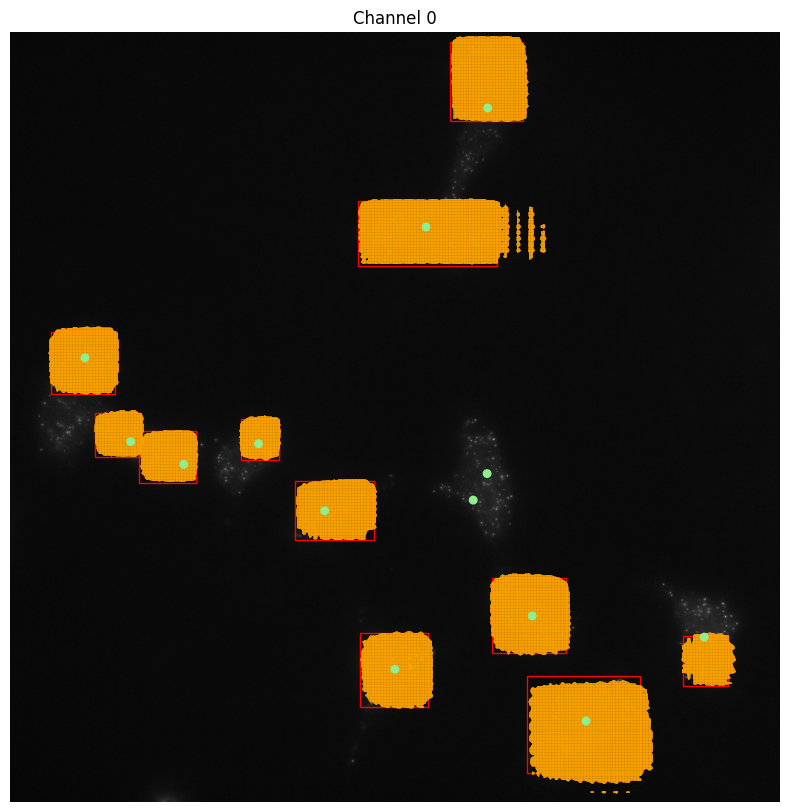

In [12]:

with tifffile.TiffFile(image_path) as tif:
    img0 = tif.pages[0].asarray()
    img1 = tif.pages[1].asarray()
    bbox1 = f.AppIntDINOwrapper(img1)
    centers = []
    for bbox in bbox1:
        x_center = (bbox[0] + bbox[2]) / 2
        y_center = (bbox[1] + bbox[3]) / 2
        centers.append((x_center, y_center))
    centers = np.array(centers)
    bbox0 = f.AppIntDINOwrapperB(img0, centers)
    result0 = f.finetune.AppIntPREDICTwrapper(img0,bbox0)

    fig, axes = plt.subplots(1, 1, figsize=(10, 10))

    axes.imshow(img0, cmap='gray')
    axes.set_title("Channel 0")
    axes.axis('off')
    for bbox in bbox0:
        axes.add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
    for mask in result0:
        y, x = np.where(mask > 0)
        axes.scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)
    for center in centers:
        axes.add_patch(Circle(center, radius=10, edgecolor='lightgreen', facecolor='lightgreen'))
    
    plt.show()

[2025-07-03 01:05:19,277][INFO] PRED: generated 10 masks
[2025-07-03 01:05:33,549][INFO] PRED: generated 13 masks


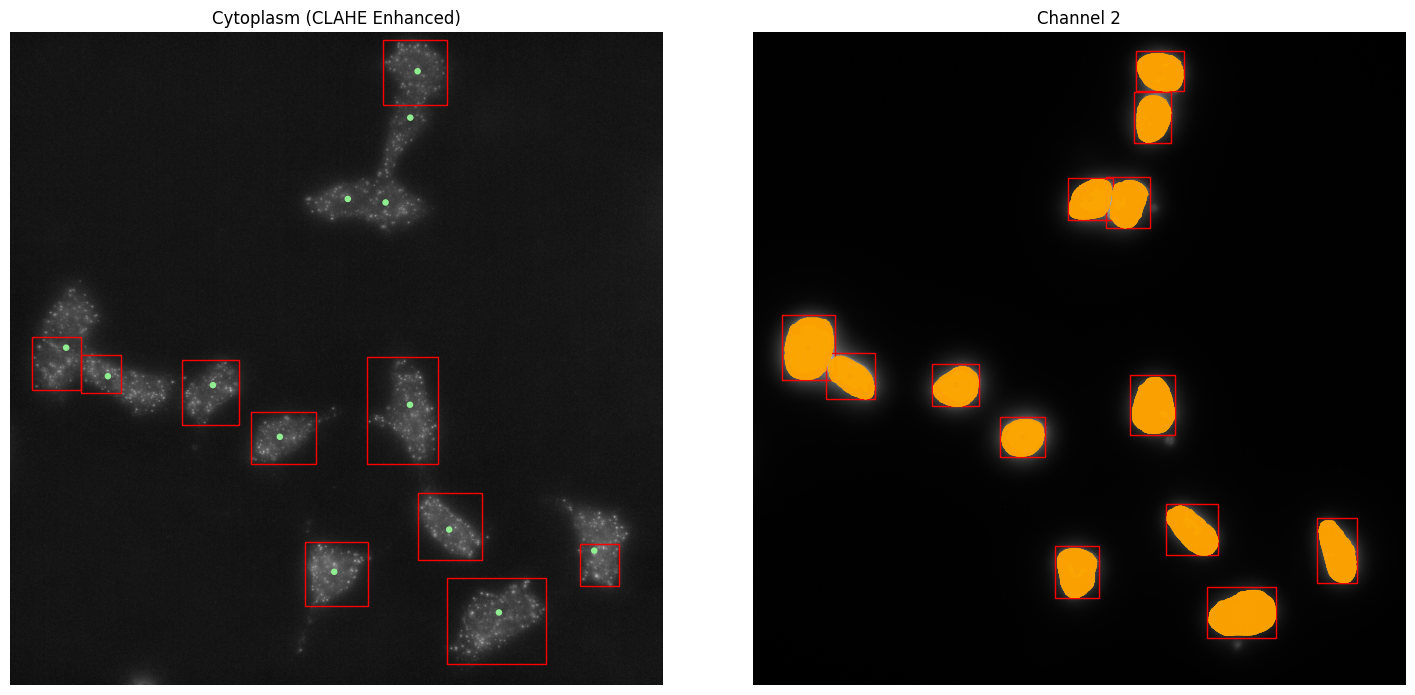

In [ ]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from skimage.morphology import remove_small_objects, binary_opening, disk
from skimage import measure
from matplotlib import cm

def normalize_to_uint8(image: np.ndarray) -> np.ndarray:
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def enhance_contrast_clahe(image: np.ndarray, clip_limit=2.0, tile_grid_size=(8, 8)) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image.astype(np.uint8))

def postprocess_mask(mask: np.ndarray) -> np.ndarray:
    if mask.ndim > 2:
        mask = np.squeeze(mask)
    if mask.ndim != 2:
        raise ValueError(f"[ERROR] postprocess_mask expected 2D input but got shape {mask.shape}")
    
    cleaned = remove_small_objects(mask.astype(bool), min_size=300)
    cleaned = binary_opening(cleaned, footprint=disk(2))
    return cleaned.astype(np.uint8)

with tifffile.TiffFile(image_path) as tif:
    cytoplasm = tif.pages[0].asarray()
    nucleus   = tif.pages[2].asarray()
    cytoplasm_norm     = normalize_to_uint8(cytoplasm)
    cytoplasm_enhanced = enhance_contrast_clahe(cytoplasm_norm)
    # nucleus_norm       = normalize_to_uint8(nucleus)
    bbox1   = f.AppIntDINOwrapper(nucleus)
    centers = np.array([((x1+x2)/2, (y1+y2)/2) for x1,y1,x2,y2 in bbox1])
    bbox0 = f.AppIntDINOwrapperB(cytoplasm_enhanced, centers)
    result0 = f.finetune.AppIntPREDICTwrapper(cytoplasm_enhanced, bbox0)
    nucleus_result = f.finetune.AppIntPREDICTwrapper(nucleus, bbox1)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Cytoplasm panel
axes[0].imshow(cytoplasm_enhanced, cmap='gray')
axes[0].set_title("Cytoplasm (CLAHE Enhanced)")
axes[0].axis('off')
for box in bbox0:
    x1,y1,x2,y2 = box
    axes[0].add_patch(Rectangle((x1,y1), x2-x1, y2-y1, edgecolor='red',   facecolor='none'))
for center in centers:
    axes[0].add_patch(Circle(center, radius=8, edgecolor='lightgreen', facecolor='lightgreen'))

# Nucleus panel
axes[1].imshow(nucleus, cmap='gray')
axes[1].set_title("Channel 2")
axes[1].axis('off')
for bbox in bbox1:
    axes[1].add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='red', facecolor='none'))
for center in centers:
    axes[1].add_patch(Circle(center, radius=6, edgecolor='blue', facecolor='none'))
for mask in nucleus_result:
    y, x = np.where(mask > 0)
    axes[1].scatter(x, y, s=0.5, c='orange', marker='.', linewidths=0)

plt.tight_layout()
plt.show()


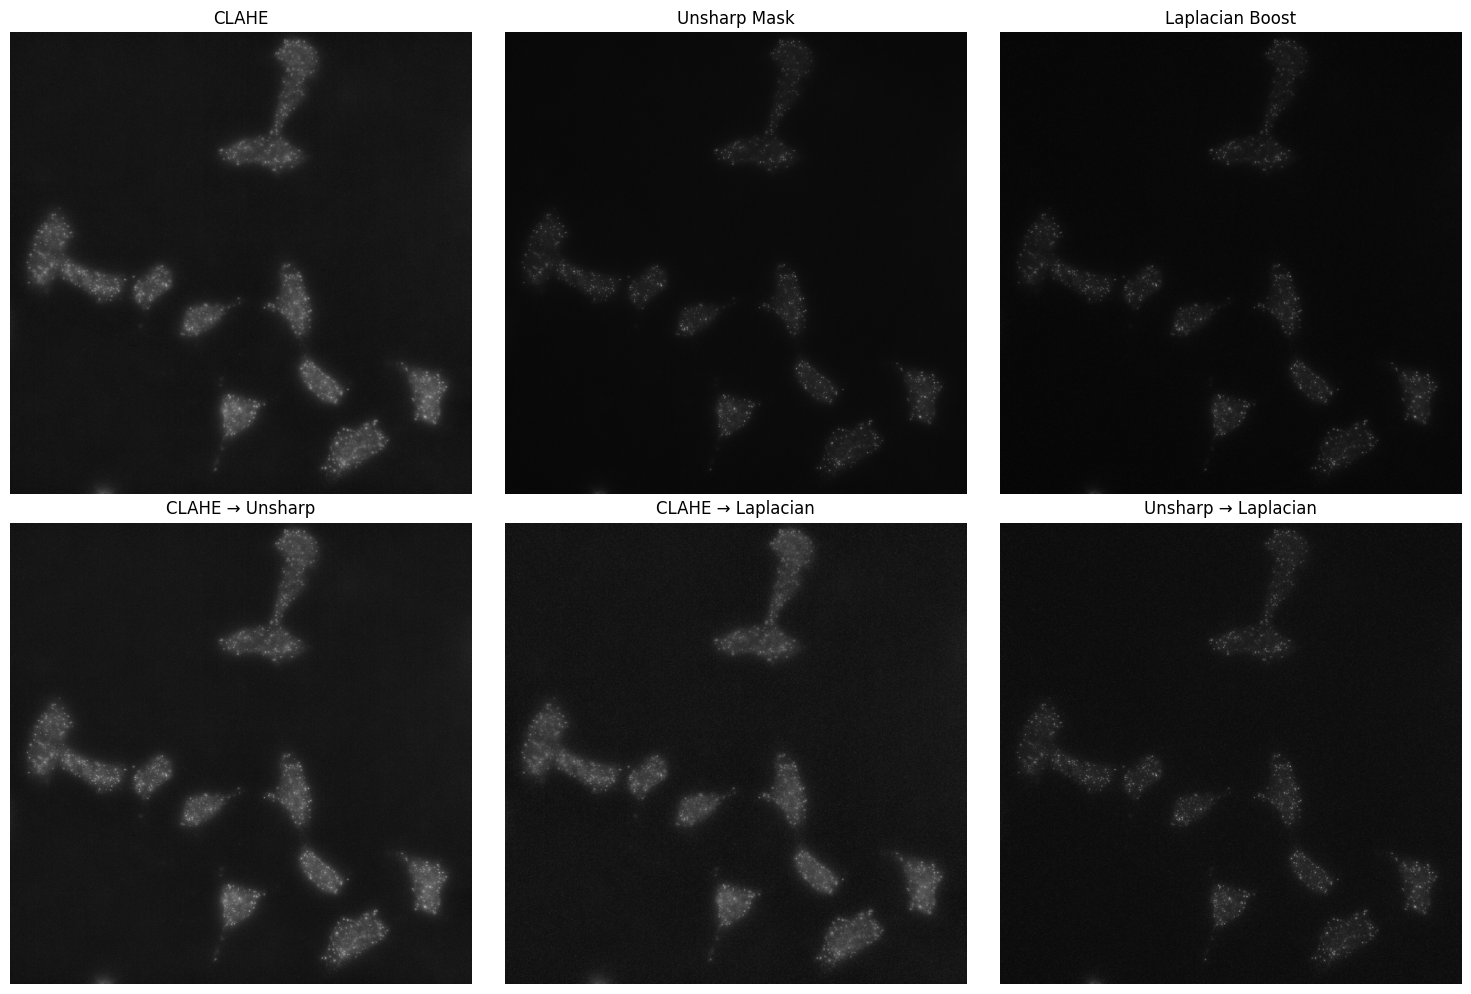

In [ ]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt

def normalize_to_uint8(image: np.ndarray) -> np.ndarray:
    return cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def enhance_clahe(image: np.ndarray,
                  clip_limit: float = 2.0,
                  tile_grid_size: tuple[int,int] = (8,8)) -> np.ndarray:
    clahe = cv2.createCLAHE(clipLimit=clip_limit,
                            tileGridSize=tile_grid_size)
    return clahe.apply(image)

def enhance_unsharp(image: np.ndarray,
                    kernel_size: tuple[int,int] = (5,5),
                    sigma: float = 1.0,
                    amount: float = 1.5) -> np.ndarray:
    blurred   = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.addWeighted(image, 1.0 + amount,
                                blurred, -amount, 0)
    return np.clip(sharpened, 0, 255).astype(np.uint8)

def enhance_laplacian(image: np.ndarray,
                      ksize: int = 3,
                      weight_orig: float = 0.8,
                      weight_edge: float = 0.2) -> np.ndarray:
    lap = cv2.Laplacian(image, cv2.CV_16S, ksize=ksize)
    lap = cv2.convertScaleAbs(lap)
    return cv2.addWeighted(image,    weight_orig,
                           lap,      weight_edge,
                           0)

from pathlib import Path
with tifffile.TiffFile(image_path) as tif:
    cyt = tif.pages[0].asarray()

cyt_norm = normalize_to_uint8(cyt)
clahe_img     = enhance_clahe(cyt_norm)
unsharp_img   = enhance_unsharp(cyt_norm)
laplacian_img = enhance_laplacian(cyt_norm)
clahe_unsharp   = enhance_unsharp(clahe_img)
clahe_laplacian = enhance_laplacian(clahe_img)
unsharp_lap     = enhance_laplacian(unsharp_img)

titles = [
    "CLAHE",
    "Unsharp Mask",
    "Laplacian Boost",
    "CLAHE → Unsharp",
    "CLAHE → Laplacian",
    "Unsharp → Laplacian"
]
images = [
    clahe_img,
    unsharp_img,
    laplacian_img,
    clahe_unsharp,
    clahe_laplacian,
    unsharp_lap
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for ax, img, title in zip(axes.ravel(), images, titles):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


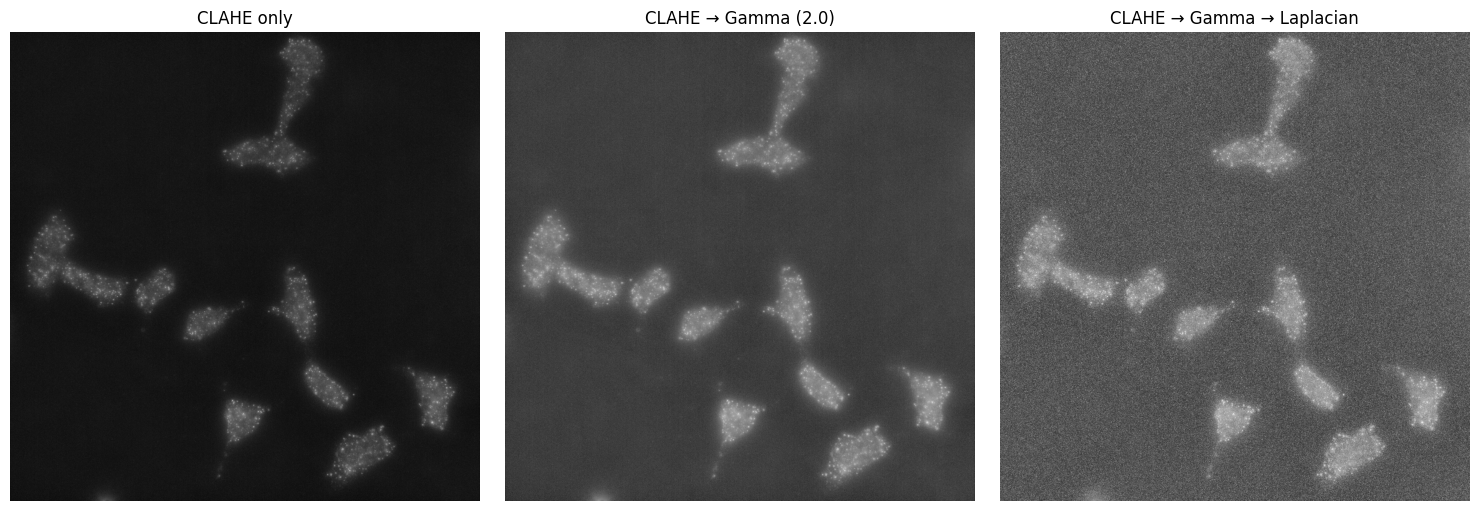

In [ ]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt

def normalize_to_uint8(img: np.ndarray) -> np.ndarray:
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def clahe(img: np.ndarray,
          clip_limit: float = 2.0,
          tile_grid_size: tuple[int,int] = (8,8)
         ) -> np.ndarray:
    c = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return c.apply(img)

def gamma_correct(img: np.ndarray, gamma: float) -> np.ndarray:
    inv = 1.0 / gamma
    table = (np.arange(256) / 255.0) ** inv * 255
    table = table.clip(0,255).astype("uint8")
    return cv2.LUT(img, table)

def laplacian_boost(img: np.ndarray,
                    ksize: int = 3,
                    weight: float = 0.5
                   ) -> np.ndarray:
    lap = cv2.Laplacian(img, cv2.CV_64F, ksize=ksize)
    lap = cv2.convertScaleAbs(lap)
    return cv2.addWeighted(img, 1.0, lap, weight, 0)

with tifffile.TiffFile(image_path) as tif:
    cyt = tif.pages[0].asarray()

cyt8 = normalize_to_uint8(cyt)

img_clahe    = clahe(cyt8)                  
img_gamma    = gamma_correct(img_clahe, 2.0)  
img_laplacian = laplacian_boost(img_gamma, ksize=3, weight=0.5)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
for ax, im, title in zip(axs,
                         [img_clahe, img_gamma, img_laplacian],
                         ["CLAHE only",
                          "CLAHE → Gamma (2.0)",
                          "CLAHE → Gamma → Laplacian"]):
    ax.imshow(im, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()


[CYTO] Starting prediction for 10 cells
[CYTO] Input image shape: (2048, 2048, 3), dtype: uint8
[CYTO] Using pre-formatted 3-channel image as RGB
[CYTO] Cell 0: box=[926, 1598, 1122, 1799], point=[1024.0, 1698.5]
[CYTO] Cell 1: box=[1278, 1446, 1480, 1655], point=[1379.0, 1550.5]
[CYTO] Cell 2: box=[1118, 1019, 1342, 1355], point=[1230.0, 1187.0]
[CYTO] Cell 3: box=[1371, 1711, 1680, 1981], point=[1525.5, 1846.0]
[CYTO] Cell 4: box=[540, 1027, 719, 1231], point=[629.5, 1129.0]
[CYTO] Cell 5: box=[1786, 1605, 1910, 1738], point=[1848.0, 1671.5]
[CYTO] Cell 6: box=[1169, 24, 1369, 228], point=[1269.0, 126.0]
[CYTO] Cell 7: box=[222, 1014, 347, 1131], point=[284.5, 1072.5]
[CYTO] Cell 8: box=[754, 1192, 960, 1353], point=[857.0, 1272.5]
[CYTO] Cell 9: box=[69, 957, 222, 1123], point=[145.5, 1040.0]
[CYTO] Completed segmentation for 10 cells


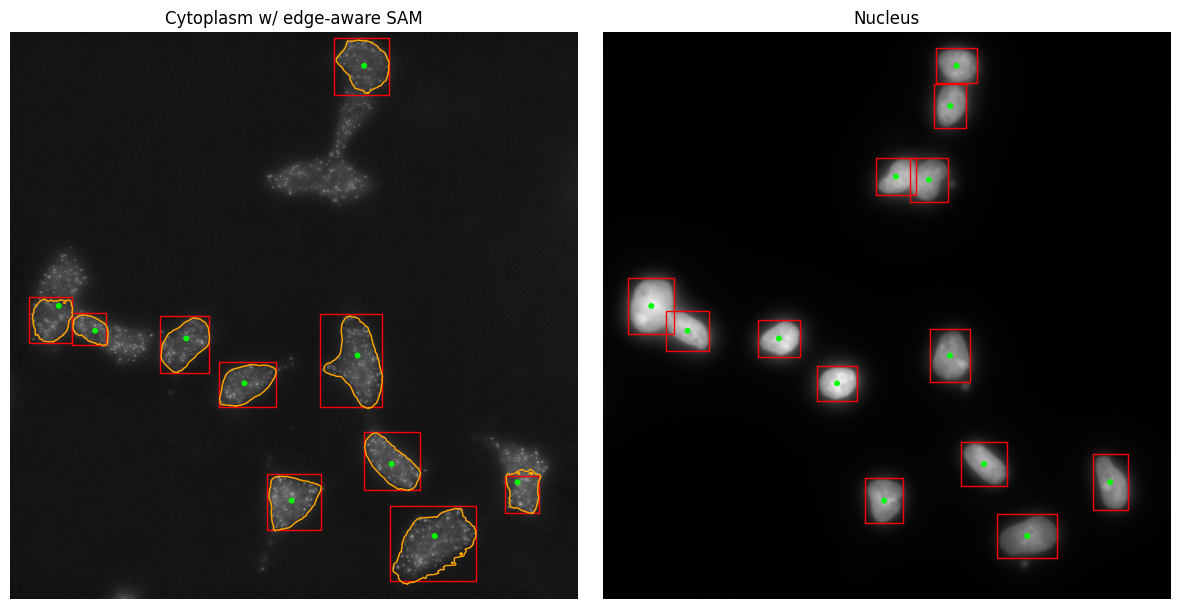

In [ ]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from skimage.morphology import remove_small_objects, binary_opening, disk
from skimage import measure

# --------------------------------------
# enhancement + edge helpers
# --------------------------------------
def normalize_to_uint8(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def clahe(img, clip_limit=2.0, tile_size=(8,8)):
    c = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    return c.apply(img)

# dilate -> erode
def gradient(img, ksize=5):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    return cv2.morphologyEx(img, cv2.MORPH_GRADIENT, kernel)

def postproc_mask(m):
    m = remove_small_objects(m.astype(bool), min_size=200)
    m = binary_opening(m, footprint=disk(2))
    return m.astype(np.uint8)

# --------------------------------------
# load & preprocess
# --------------------------------------
with tifffile.TiffFile(image_path) as tif:
    cyt0 = tif.pages[0].asarray()      
    nucleus = tif.pages[2].asarray()    

cyt8 = normalize_to_uint8(cyt0)
cyt_clahe = clahe(cyt8)
cyt_grad  = gradient(cyt_clahe, ksize=7)

cyt_rgb = np.stack([cyt_clahe, cyt_clahe, cyt_grad], axis=-1)
bbox_nucleus = f.AppIntDINOwrapper(nucleus)
centers  = [((x1+x2)/2, (y1+y2)/2) for x1,y1,x2,y2 in bbox_nucleus]
bbox_cyto = f.AppIntDINOwrapperB(cyt_clahe, np.array(centers))
masks_all = f.finetune.AppIntPREDICTCytoplasmWrapper(cyt_rgb, bbox_cyto)

masks = []
for mset in masks_all:
    areas = [(mm>0).sum() for mm in mset]
    best = mset[np.argmax(areas)]
    masks.append(best)
masks = [postproc_mask(m) for m in masks]

# --------------------------------------
# plot
# --------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Cytoplasm Panel
ax[0].imshow(cyt_clahe, cmap='gray')
ax[0].set_title("Cytoplasm w/ edge‐aware SAM")
ax[0].axis('off')
for (x1,y1,x2,y2), c in zip(bbox_cyto, centers):
    ax[0].add_patch(Rectangle((x1,y1), x2-x1, y2-y1,
                              edgecolor='red', facecolor='none', lw=1))
    ax[0].add_patch(Circle(c, radius=8, edgecolor='lime', facecolor='lime'))
for m in masks:
    for contour in measure.find_contours(m, 0.5):
        ax[0].plot(contour[:,1], contour[:,0], c='orange', lw=1)

# Nucleus Panel
ax[1].imshow(nucleus, cmap='gray')
ax[1].set_title("Nucleus")
ax[1].axis('off')
for (x1,y1,x2,y2), c in zip(bbox_nucleus, centers):
    ax[1].add_patch(Rectangle((x1,y1), x2-x1, y2-y1,
                              edgecolor='red', facecolor='none', lw=1))
    ax[1].add_patch(Circle(c, radius=8, edgecolor='lime', facecolor='lime'))

plt.tight_layout()
plt.show()